<a href="https://colab.research.google.com/github/jangvu/Project_by_me/blob/main/RCNN_scratch_airplaindataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

R-CNN stands for Regions with CNN. In R-CNN instead of running classification on huge number of regions we pass the image through selective search and select first 2000 region proposal from the result and run classification on that. In this way instead of classifying huge number of regions we need to just classify first 2000 regions.

There are 4 steps in R-CNN. They are as follows :-
1. Pass the image through selective search and generate region proposal.
2. Calculate IOU (intersection over union) on proposed region with ground truth data and add label to the proposed regions.
3. Do transfer learning using the proposed regions with the labels.
4. Pass the test image to selective search and then pass the first 2000 proposed regions from the trained model and predict the class of those regions.


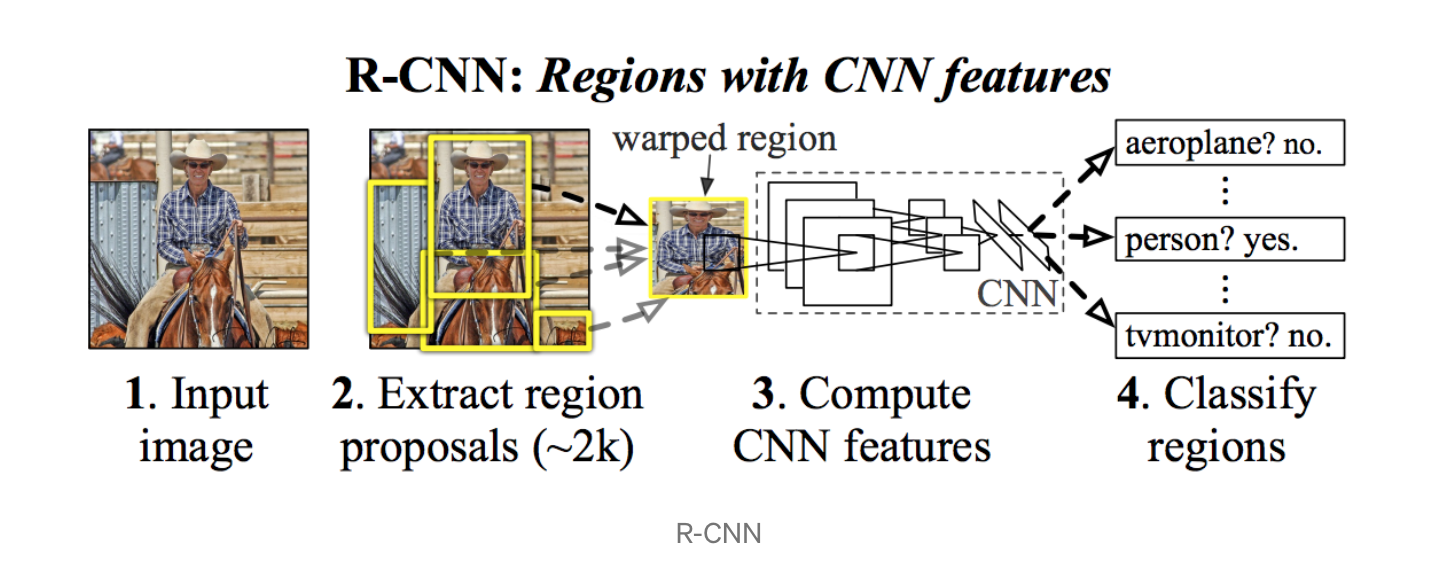

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Data/Airplane_RCNN

Airplanes_Annotations.zip  Images.zip


In [ ]:
!unzip -q "/content/drive/MyDrive/Data/Airplane_RCNN/Images.zip"

replace Images/airplane_007.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip -q "/content/drive/MyDrive/Data/Airplane_RCNN/Airplanes_Annotations.zip"

In [ ]:
IMAGES_PATH = '/content/Images'
ANNOTATIONS_PATH = '/content/Airplanes_Annotations'

In [ ]:
IMAGES_DIR = os.listdir(IMAGES_PATH)
ANNOTATIONS_DIR = os.listdir(ANNOTATIONS_PATH)

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
images_arr = []
annotations_arr = []
for image in IMAGES_DIR:
    images_arr.append(IMAGES_PATH + "/" + image)
for annotation in ANNOTATIONS_DIR:
    annotations_arr.append(ANNOTATIONS_PATH + "/" + annotation)

images_arr.sort()
annotations_arr.sort()

print('Number of images: ' + str(len(images_arr)))

Number of images: 733


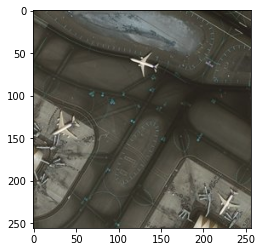

In [ ]:
image = cv2.imread(images_arr[6])
plt.imshow(image)

In [ ]:
df = pd.read_csv(annotations_arr[0])
print('lenght of df:' + str(len(df)))
for i in range(len(df)):
#  print(df.iloc[i][0].split())
  x1 = df.iloc[i][0].split()[0]
  y1 = df.iloc[i][0].split()[1]
  x2 = df.iloc[i][0].split()[2]
  y2 = df.iloc[i][0].split()[3]
  print(x1)
  print(i)


lenght of df:4
15
0
10
1
74
2
233
3


**Creating selective search**

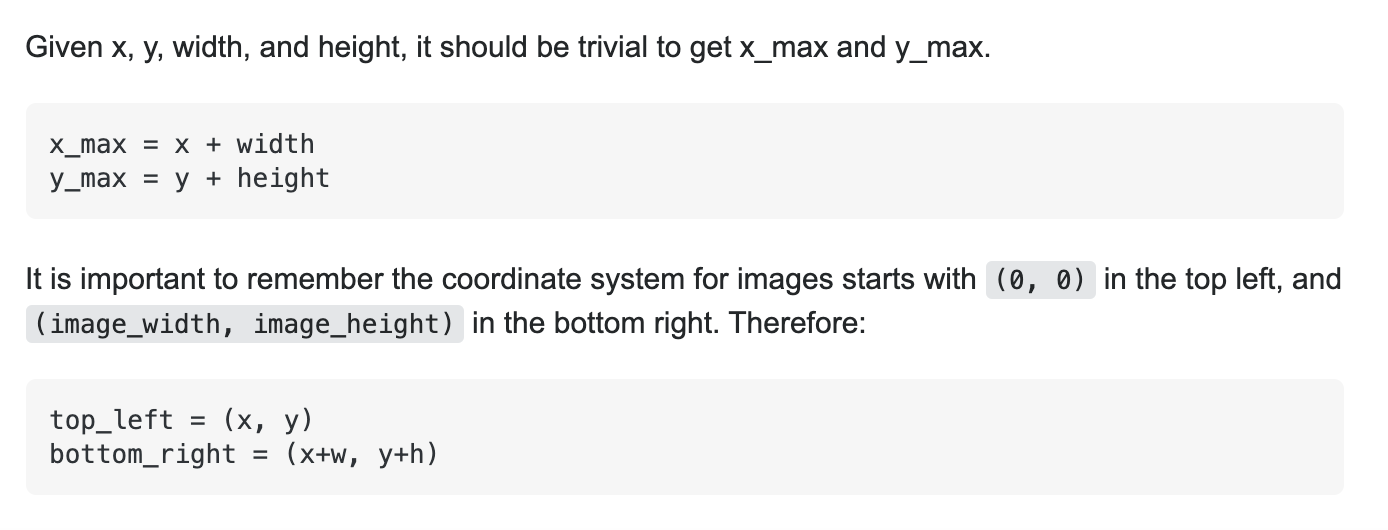

- Xmin, Ymin are top-left
- Xmax, Ymax are bot-right

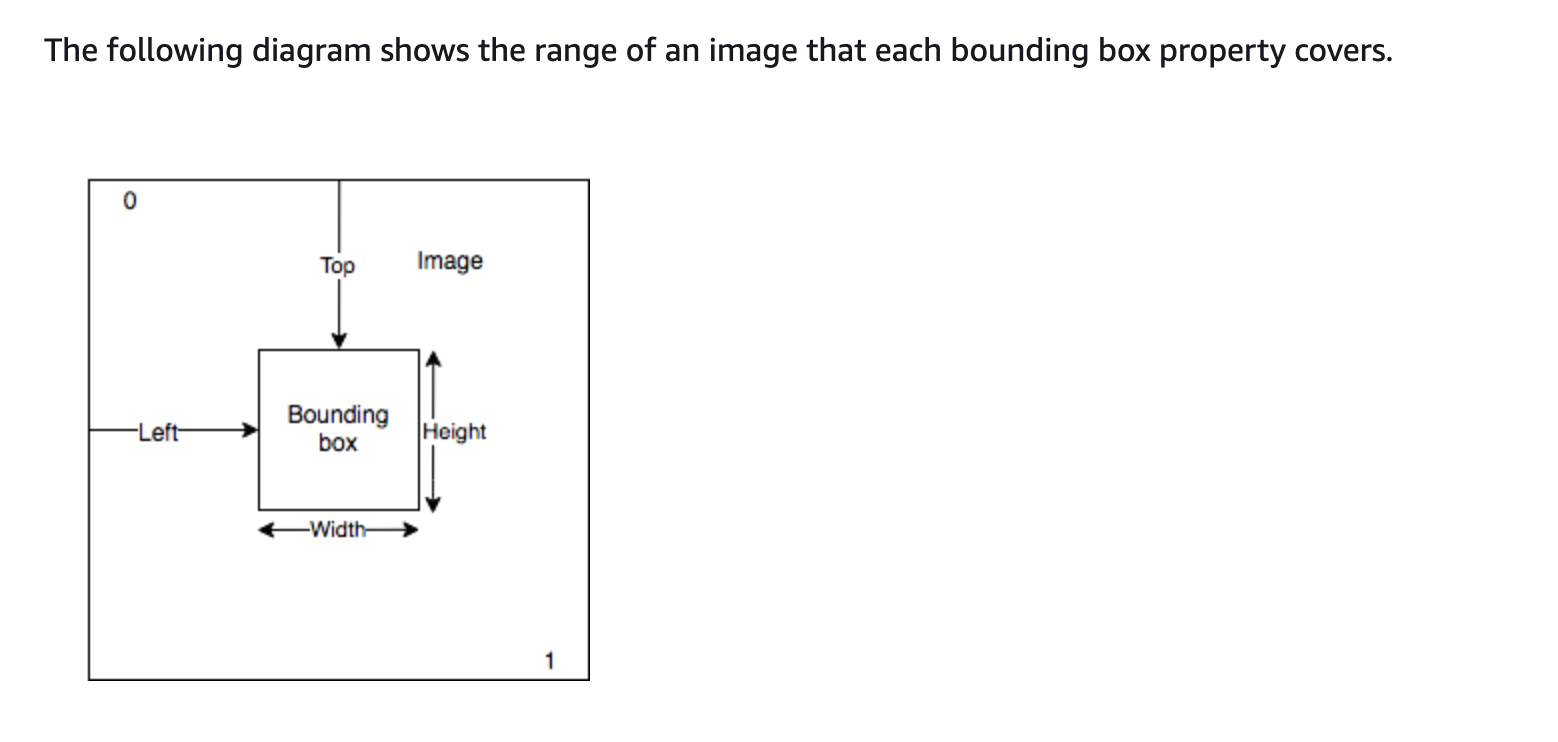

To deal with selective search, firstly we should understand IoU 

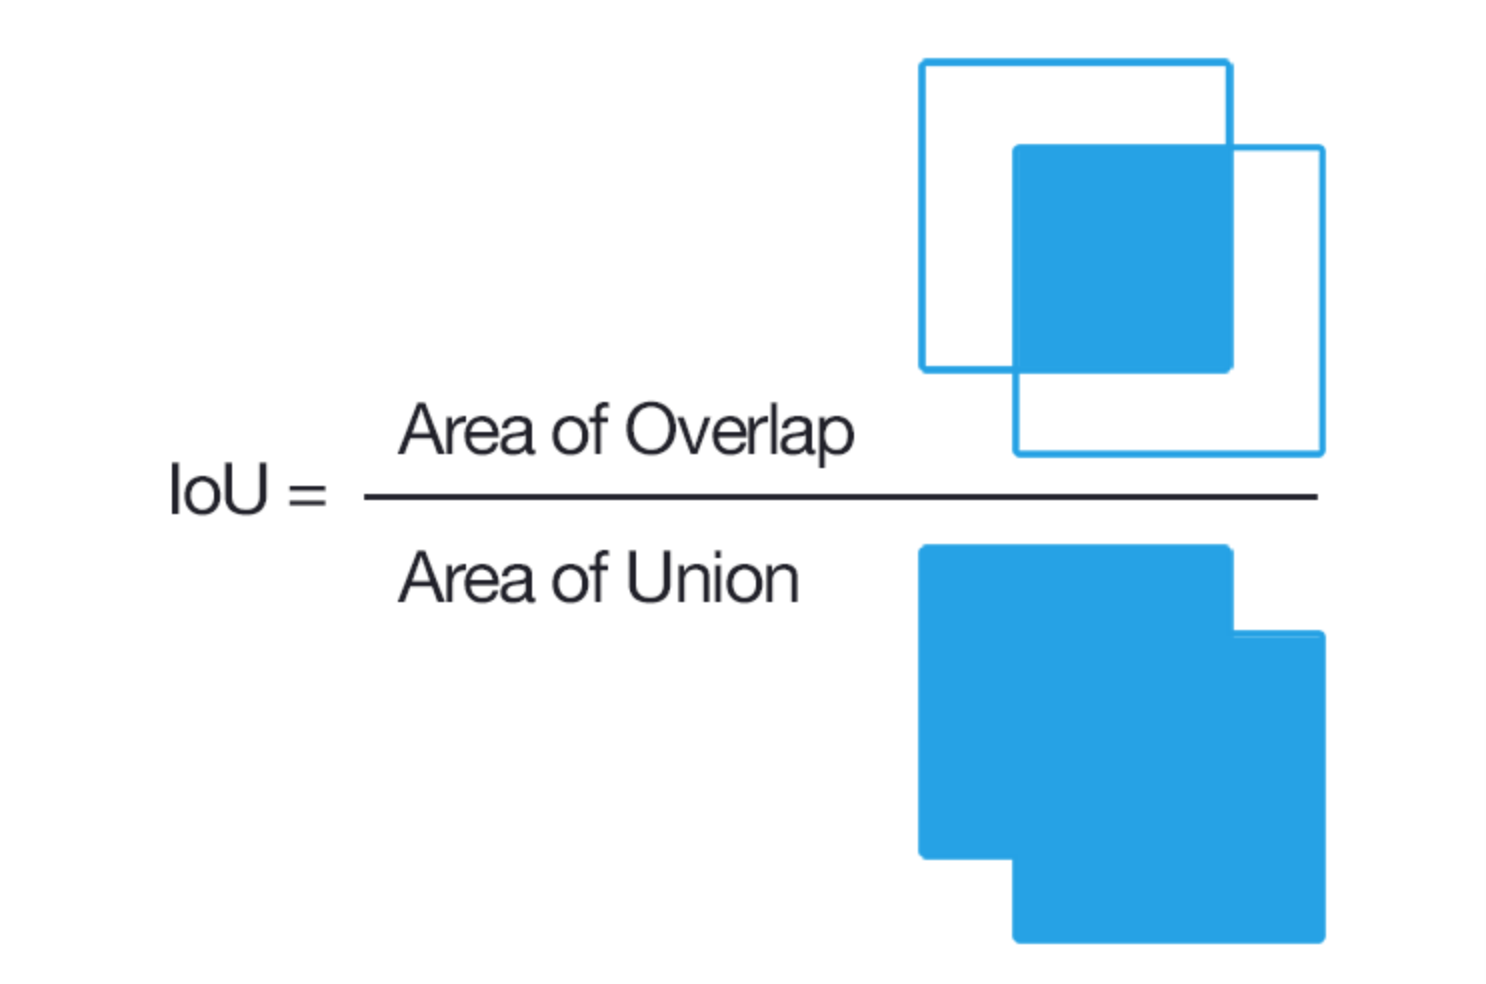

In [ ]:
def get_iou(bb1, bb2):
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']
  
  x_left = max(float(bb1['x1']), float(bb2['x1']))
  y_top = max(float(bb1['y1']), float(bb2['y1']))
  x_right = min(float(bb1['x2']), float(bb2['x2']))
  y_bot = min(float(bb1['y2']), float(bb2['y2']))
  if x_right < x_left or y_bot < y_top:
    return 0.0
  area_of_overlapping = (x_right - x_left)*(y_bot - y_top)

  bb1_area = (float(bb1['x2']) - float(bb1['x1'])) * (float(bb1['y2']) - float(bb1['y1']))
  bb2_area = (float(bb2['x2']) - float(bb2['x1'])) * (float(bb2['y2']) - float(bb2['y1']))

  iou = area_of_overlapping / float(bb1_area + bb2_area - area_of_overlapping)
  return iou


**Demo selective search**

Test with 1 image

In [ ]:
image = cv2.imread(images_arr[3])
df = pd.read_csv(annotations_arr[3])
len(df)
bb_values = []
for i in range(len(df)):
#  print(df.iloc[i][0].split())
  x1 = df.iloc[i][0].split()[0]
  y1 = df.iloc[i][0].split()[1]
  x2 = df.iloc[i][0].split()[2]
  y2 = df.iloc[i][0].split()[3]
  bb_values.append({'x1':int(x1), 'y1':int(y1), 'x2':int(x2), 'y2':int(y2)})

imout = image.copy()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

print('bb_values: '+ str(bb_values))
print(ssresults)
print(len(ssresults))


bb_values: [{'x1': 176, 'y1': 12, 'x2': 207, 'y2': 41}, {'x1': 155, 'y1': 47, 'x2': 188, 'y2': 82}, {'x1': 86, 'y1': 125, 'x2': 118, 'y2': 160}, {'x1': 54, 'y1': 108, 'x2': 83, 'y2': 134}, {'x1': 0, 'y1': 65, 'x2': 22, 'y2': 104}]
[[194  98  13  21]
 [ 99   0 112  69]
 [214 191  12  15]
 ...
 [  0  46 256 210]
 [ 63   0 148 106]
 [  0   0 256 196]]
397


In [ ]:
for i in bb_values:
  print(i)

{'x1': 176, 'y1': 12, 'x2': 207, 'y2': 41}
{'x1': 155, 'y1': 47, 'x2': 188, 'y2': 82}
{'x1': 86, 'y1': 125, 'x2': 118, 'y2': 160}
{'x1': 54, 'y1': 108, 'x2': 83, 'y2': 134}
{'x1': 0, 'y1': 65, 'x2': 22, 'y2': 104}


In [ ]:
#img_draw = image.copy()
train_images=[]
train_labels=[]
counter = 0
falsecounter = 0
flag = 0
fflag = 0
bflag = 0
points = []
for index, values in enumerate(ssresults):
  if index < 300:
    for bb in bb_values:
      x,y,w,h = values
      start_point = (x,y)
      end_point = (x+w,y+h)
      iou = get_iou(bb,{"x1":x,"y1":y,"x2":x+w,"y2":y+h})
      if iou > 0.70 and counter < 10:
        points.append([start_point,end_point])
#        color = [random.randint(0, 255) for j in range(0, 3)]
#        cv2.rectangle(img_draw, (x, y), (x + w, y + h), color, 2)
#        cv2_imshow(img_draw)
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        train_images.append(resized)
        train_labels.append(1)
        counter += 1
      if iou < 0.3:
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        train_images.append(resized)
        train_labels.append(0)


In [ ]:
x,y,w,h = ssresults[0]

iou: 0.009967352592006332


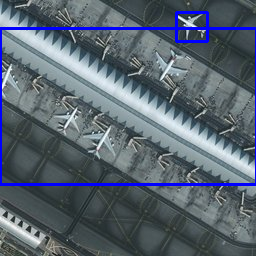

In [ ]:
bb_values[0]
bb2 = {'x1':x, 'y1':y, 'x2': x+w, 'y2': y+h}
iou = get_iou(bb_values[0],bb2)
print('iou: ' + str(iou))
# Blue color in BGR 
color = (255, 0, 0) 
# Line thickness of 2 px 
thickness = 2
img_draw = image.copy()
cv2.rectangle(img_draw,(bb_values[0]['x1'],bb_values[0]['y1']),(bb_values[0]['x2'],bb_values[0]['y2']),color,thickness)
cv2.rectangle(img_draw,(x,y),(x+w,y+h),color,thickness)
cv2_imshow(img_draw)  

In [ ]:
counter
  

7

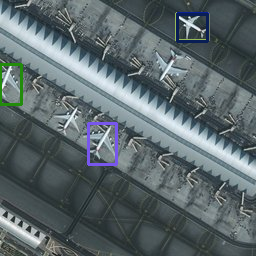

In [ ]:
import random
img_draw = image.copy()
for i in points:
#  img_draw = image.copy()
  color = [random.randint(0, 255) for j in range(0, 3)]
  cv2.rectangle(img_draw, i[0], i[1], color, 2)
cv2_imshow(img_draw)
key = cv2.waitKey(0) & 0xFF

Applying 

In [ ]:
#ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
train_images=[]
train_labels=[]
for i in range(len(images_arr)):
  if 'airplane' in images_arr[i]:
    print(images_arr[i])
    image = cv2.imread(images_arr[i])
    df = pd.read_csv(annotations_arr[i])
    bb_values = []
    for j in range(len(df)):
      x1 = int(df.iloc[j][0].split()[0])
      y1 = int(df.iloc[j][0].split()[1])
      x2 = int(df.iloc[j][0].split()[2])
      y2 = int(df.iloc[j][0].split()[3])
      bb_values.append({'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2})
      print(str(j) + 'value')
    imout = image.copy()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    counter = 0
    false_counter = 0
    flag = 0
    b_flag = 0
    false_flag = 0
    for index, values in enumerate(ssresults):
      if index < 2000 and flag == 0:
        for bb in bb_values:
          print(values)
          x,y,w,h = values
          iou = get_iou(bb,{"x1":x,"y1":y,"x2":x+w,"y2":y+h})
          if counter < 30:
            if iou > 0.7:
              timage = imout[y:y+h,x:x+w]
              resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
              train_images.append(resized)
              train_labels.append(1)
              counter += 1
            else:
              b_flag = 1
          if false_counter < 30:
            if iou < 0.3:
              timage = imout[y:y+h,x:x+w]
              resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
              train_images.append(resized)
              train_labels.append(0)
              false_counter += 1
            else:
              false_flag = 1
        if b_flag == 1 & false_flag == 1:
          print('inside')
          flag = 1 


Streaming output truncated to the last 5000 lines.
[ 95 112  41  79]
[ 95 112  41  79]
[ 95 112  41  79]
[ 95 112  41  79]
[ 95 112  41  79]
[ 95 112  41  79]
[ 0 10 22 26]
[ 0 10 22 26]
[ 0 10 22 26]
[ 0 10 22 26]
[ 0 10 22 26]
[ 0 10 22 26]
[ 0 10 22 26]
[ 0 10 22 26]
[223 214  23  11]
[223 214  23  11]
[223 214  23  11]
[223 214  23  11]
[223 214  23  11]
[223 214  23  11]
[223 214  23  11]
[223 214  23  11]
[23  0 21 15]
[23  0 21 15]
[23  0 21 15]
[23  0 21 15]
[23  0 21 15]
[23  0 21 15]
[23  0 21 15]
[23  0 21 15]
[135 164  27  86]
[135 164  27  86]
[135 164  27  86]
[135 164  27  86]
[135 164  27  86]
[135 164  27  86]
[135 164  27  86]
[135 164  27  86]
[111  57  62  27]
[111  57  62  27]
[111  57  62  27]
[111  57  62  27]
[111  57  62  27]
[111  57  62  27]
[111  57  62  27]
[111  57  62  27]
[119  46  83  96]
[119  46  83  96]
[119  46  83  96]
[119  46  83  96]
[119  46  83  96]
[119  46  83  96]
[119  46  83  96]
[119  46  83  96]
[ 21 114  39  45]
[ 21 114  39  45]
[ 21 

In [ ]:
len(train_images)

1739

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)


In [ ]:

from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])


In [ ]:
model_final.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
type(y_new)

numpy.ndarray

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)


In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
10/10 [==============================] - 49s 1s/step - loss: 0.9838 - accuracy: 0.7655 - val_loss: 0.3313 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 0.33133, saving model to ieeercnn_vgg16_1.h5
Epoch 2/1000
10/10 [==============================] - 5s 488ms/step - loss: 0.4195 - accuracy: 0.8689 - val_loss: 0.1786 - val_accuracy: 0.9375

Epoch 00002: val_loss improved from 0.33133 to 0.17858, saving model to ieeercnn_vgg16_1.h5
Epoch 3/1000
10/10 [==============================] - 5s 490ms/step - loss: 0.2409 - accuracy: 0.8931 - val_loss: 0.2528 - val_accuracy: 0.9375

Epoch 00003: val_loss did not improve from 0.17858
Epoch 4/1000
10/10 [==============================] - 5s 479ms/step - loss: 0.1923 - accuracy: 0.9349 - val_loss: 0.1421 - val_accuracy: 0.9062

Epoch 00004: val_loss improved from 0.17858 to 0.14209, saving model to ieeercnn_vgg16_1.h5
Epoch 5/1000
10/10 [==============================] - 5s 492ms/step - loss: 0.1313 - accuracy: 0.96

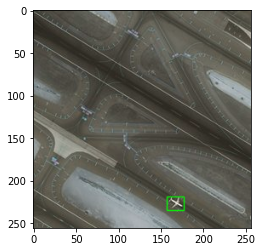

In [ ]:
#for i in range(11):
image = cv2.imread(images_arr[5])
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = image.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.65:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)